# Backtest

In [1]:
import os, time, logging
from datetime import date, datetime, timedelta

import numpy as np
import pandas as pd

import warnings
warnings.simplefilter('ignore')

In [2]:
from technicals import TechnicalAnalysis
import data.marketdata.alpaca as api
import data.io.twilio as tw

In [3]:
import matplotlib.pyplot as plt

In [4]:
tickers = ['SQ','SSTK','ATVI','GOOG','SYK','VOD','OLN','ARE', 'DIS', 'C']
api_key_path = '../resources/api_keys.env'

In [5]:
ohlcv = api.ohlcv(tickers=tickers, api_key_path=api_key_path)

In [6]:
technicals = TechnicalAnalysis(ohlcv)

Open price data for ARE


<AxesSubplot:xlabel='time'>

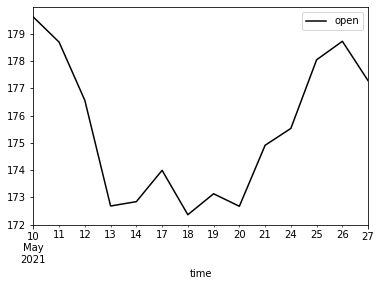

In [7]:
print(f"Open price data for {technicals.tickers()[0]}")
technicals._open(ticker=technicals.tickers()[0]).tail(14).plot(color='black')

### *Backtesting Williams %R*

#### Test class method

In [8]:
#set backtest bounds logic
wr_rules = {'long' : -80,
             'short' : -70}

wr_range = 10

# set cash position and tracker
seed_cash = 1000000.0

In [9]:
backtest_test = technicals.wr_backtest(ticker = 'SQ',
                                       start_date = '2018-01-01',
                                       end_date = '2021-05-01',
                                       wr_rules = wr_rules,
                                       seed_cash = seed_cash,
                                       wr_range=wr_range)

In [10]:
backtest_test.head()

,time,close,wr,pos,stock_value,shares,cash,Hold,Trade
0,2020-01-16 00:00:00-05:00,69.53,-14.893617,False,0,0,1000000,1000000.000000,1000000
1,2020-01-17 00:00:00-05:00,69.38,-16.413374,False,0,0,1000000,997842.657846,1000000
2,2020-01-21 00:00:00-05:00,68.31,-36.648501,False,0,0,1000000,982453.617144,1000000
3,2020-01-22 00:00:00-05:00,68.69,-33.722628,False,0,0,1000000,987918.883935,1000000
4,2020-01-23 00:00:00-05:00,69.29,-39.767442,False,0,0,1000000,996548.252553,1000000


<AxesSubplot:>

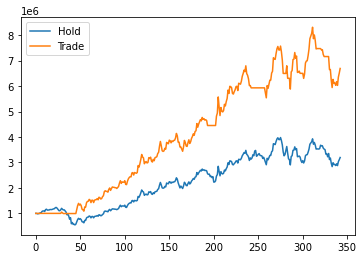

In [11]:
backtest_test[['Hold','Trade']].plot()

### *Backtest study*

In [12]:
start_date = '2018-01-01'
end_date = '2021-05-01'

In [13]:
long_params = list(range(-85,-25, 3))
# long_params = [-81, -80, -79]

long_params[:10]

[-85, -82, -79, -76, -73, -70, -67, -64, -61, -58]

In [14]:
short_params = list(range(-45,-75, -3))
# short_params = [-69, -70, -71]

short_params[:10]

[-45, -48, -51, -54, -57, -60, -63, -66, -69, -72]

In [15]:
wr_ranges = [5,10,15,20,30,60,90,180]
# wr_ranges = [5, 10, 15]

wr_ranges

[5, 10, 15, 20, 30, 60, 90, 180]

In [16]:
# ticker_paths : dict() of str : Path
# exchange = 'nyse'
# tickers_df = pd.read_csv(os.path.join('data','tickers', str(exchange + '.csv')))

# tickers = ['DIS', 'C']

tickers_df = pd.read_csv('data/tickers/finviz-midcap-PE_growth.csv')
tickers = tickers_df["Ticker"].to_list()

In [17]:
# Load Twillio progress reporting
to_phone = input()
tw.load_twilio_api(api_key_path)
tw.send_message(message = f"Backtest Begins | {str(date.today())}", to_phone = to_phone)

 +17183002567


In [18]:
def backtest_wr(path):

    # instantiate data dump dictionary
    data_dump = {}
    
    # csv header bool
    first_time = True
    
    # ticker counter
    counter = 1

    for ticker in tickers:
        
        date_ = str(date.today())
        time_ = str(datetime.now().strftime("%H:%M:%S"))
        message = f"Backtesting : {ticker} | {int((counter-1/len(tickers))*100)}% Complete | {date_} {time_}"
        tw.send_message(message = message, to_phone = to_phone)
        print(message)
        counter += 1
        
        # get stock data and clean up df
        ohlcv = api.ohlcv(tickers=[ticker],
                          api_key_path=api_key_path,
                          start_date=start_date,
                          end_date=end_date)
        
        # instantiate a TechnicalAnalysis class
        stock = TechnicalAnalysis(ohlcv)
        
        for wr_range in wr_ranges:
            for long in long_params:
                for short in short_params:
                    
                    try:
                        result_df = pd.DataFrame(columns=['ticker',
                                          'wr_range',
                                          'long_trigger',
                                          'short_trigger',
                                          'hold_return_pct',
                                          'trade_return_pct', 
                                          'delta_return',
                                          'delta_return_pct_diff'])

                        # set backtest bounds logic
                        wr_rules = {'long' : long,
                                     'short' : short}

                        # set cash position and tracker
                        seed_cash = 1000000.0

                        # set backtest parameters
                        data = stock.wr_backtest(ticker=ticker,
                                                 wr_rules = wr_rules,
                                                 seed_cash = seed_cash,
                                                 wr_range = wr_range,
                                                 start_date = start_date,
                                                 end_date = end_date)

                        init_hold_shares = data.iloc[0]['cash']/data.iloc[0]['close']

                        # parse data
                        data = data.set_index('time')

                        # process results data
                        hold_return = (data['Hold'][-1]-data['Hold'][0])/data['Hold'][0]
                        trade_return = (data['Trade'][-1]-data['Trade'][0])/data['Trade'][0]
                        delta_return = trade_return - hold_return
                        pct_delta_return = (trade_return - hold_return)/hold_return


                        result = {'ticker' : ticker,
                                  'wr_range' : wr_range,
                                  'long_trigger' : long,
                                  'short_trigger' : short,
                                  'hold_return_pct' : hold_return,
                                  'trade_return_pct' : trade_return,
                                  'delta_return' : delta_return,
                                  'delta_return_pct_diff' : pct_delta_return}

                        result_df = result_df.append(result, ignore_index=True)

                        if first_time:
                            result_df.to_csv(path, mode='w')
                            first_time = False
                        else:
                            result_df.to_csv(path, mode='a', header=False)    
                            
                    except:
                        print(f"Could not process {ticker} -> W%R range = {wr_range}; long bound = {long}; short bound = {short}")
                        
    
    
    date_ = str(date.today())
    time_ = str(datetime.now().strftime("%H:%M:%S"))
    message = f"Backtesting : Complete | 100% Complete | {date_} {time_}"
    tw.send_message(message = message, to_phone = to_phone)
    print(message)

In [19]:
_path = 'data/results/2021_05_27-backtest-midcap_PE_growth.csv'

In [ ]:
backtest_wr(_path)

Backtesting : APPF | 3% Complete | 2021-05-27 19:47:03
Could not process APPF -> W%R range = 5; long bound = -76; short bound = -63


In [ ]:
df = pd.read_csv(_path)

In [ ]:
df.head()

In [ ]:
print(len(df.index))

In [ ]:
# df.to_csv('2021_05_25-backtest-midcap-PE_growth.csv')

In [ ]:
filtered_df = df[df['delta_return_pct_diff'] > 1]
filtered_df

In [ ]:
len(filtered_df.index)/len(df.index)*100

In [ ]:
filtered_df.describe()

In [ ]:
filtered_df.delta_return_pct_diff.sort_values().plot.hist()

In [ ]:
plt.scatter(filtered_df.delta_return_pct_diff, filtered_df.wr_range)

In [ ]:
plt.scatter(filtered_df.delta_return_pct_diff, filtered_df.long_trigger)

In [ ]:
plt.scatter(filtered_df.delta_return_pct_diff, filtered_df.short_trigger)